# Notebook to look at wbf vs spike rate plots

In particular, worried about the fact that both wbf and spike rate are made kind of artificially continuous (or, for wbf, there's overlap in the STFT). So how to sample time series to capture variation but not be redundant?

## Imports

In [19]:
import os 
import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from matplotlib import rcParams
from mosquito.process_abf import load_processed_data
# from mosquito.read_photron import my_read_cih, my_read_mraw

## Params

In [20]:
# plotting preferences
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels

## Load data

In [46]:
# look at example data set first
data_folder = '31_20240611'  # '29_20240530'  # '28_20240529'
axo_num = 6  # 0  # 7  # 8

data = load_processed_data(data_folder, axo_num)


In [47]:
# read out some data
wbf = data['wbf']
t = data['time']
spike_rate = data['spike_rate']
spike_idx = data['spike_idx'] 
flying_idx = data['flying_idx']

window = data['params']['emg_window']
fs = data['sampling_freq']

In [48]:
# x = data['wbf']
# y = data['spike_rate']

# # ----------------------------------------------------
# # ADD THESE 3 LINES TO TAKE ONLY DATA DURING FLIGHT
# flying_idx = data['flying_idx']
# x = x[flying_idx]
# y = y[flying_idx]
# # ----------------------------------------------------

## What does plot look like for fully continuous data?

Text(0.5, 1.0, 'wbf vs burst rate, kernel mult')

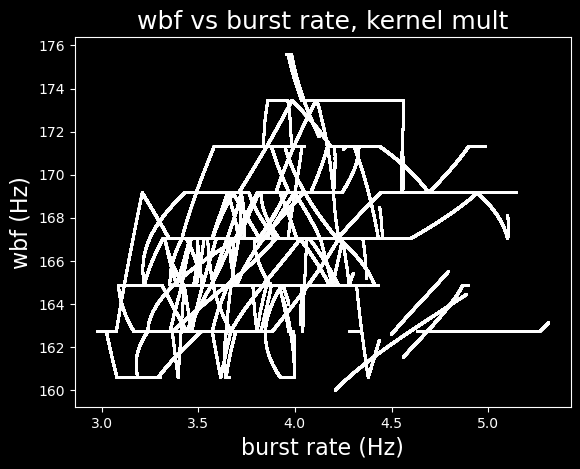

In [49]:
# make initial plot
fig, ax = plt.subplots()

ax.plot(spike_rate[flying_idx], wbf[flying_idx], 'w.', ms=1)

ax.set_xlabel('burst rate (Hz)')
ax.set_ylabel('wbf (Hz)')
ax.set_title('wbf vs burst rate, kernel mult')


Text(0, 0.5, 'wbf (Hz)')

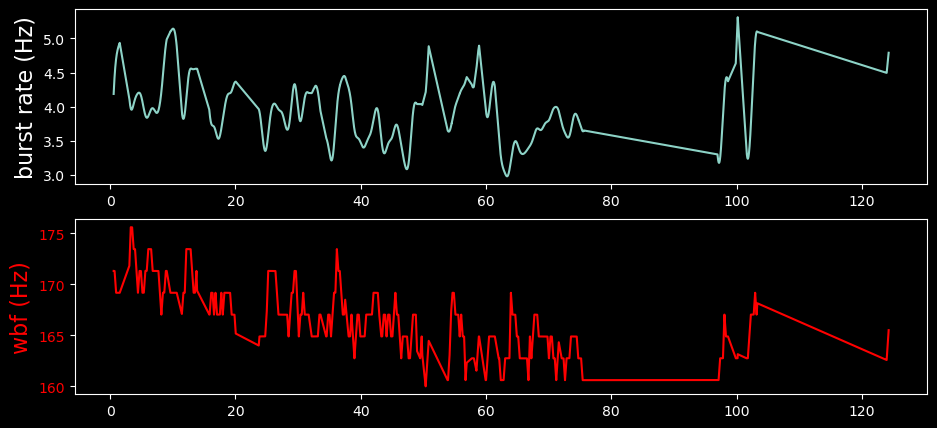

In [51]:
# look at time series plots
# fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 5), sharex=True)
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(11, 5))

ax0.plot(t[flying_idx], spike_rate[flying_idx])
ax0.set_ylabel('burst rate (Hz)') 

#ax1 = ax0.twinx()
color = 'r'
ax1.plot(t[flying_idx], wbf[flying_idx],  color='r')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('wbf (Hz)', color=color) 

In [52]:
mean_isi = np.mean(np.diff(spike_idx))  # guess how big we need gaussian to be
win_std = int(2**np.ceil(np.log2(mean_isi)))
win_n_pts = 8*win_std
win_n_pts

131072

## Try simple binning

In [53]:
# define bin edges
bin_width = 262144/4
bin_edges = np.arange(0, wbf.size, bin_width)
bin_idx = np.digitize(np.arange(wbf.size), bin_edges)


In [54]:
# collect data in bins (use pandas)
d = {'time': t[flying_idx], 
     'wbf': wbf[flying_idx], 
     'spike_rate': spike_rate[flying_idx], 
     'bin_idx': bin_idx[flying_idx]}
df = pd.DataFrame(data=d)

df_binned = df.groupby(['bin_idx']).mean()
# df_binned

In [55]:
# do a linear fit to binned results
m,b = np.polyfit(df_binned['spike_rate'][1:-1],  df_binned['wbf'][1:-1], 1)


In [56]:
1/m

0.5421494027551607

In [57]:
# correlation coefficient
df_binned[['spike_rate', 'wbf']][1:-1].corr()

,spike_rate,wbf
spike_rate,1.000000,0.266475
wbf,0.266475,1.000000


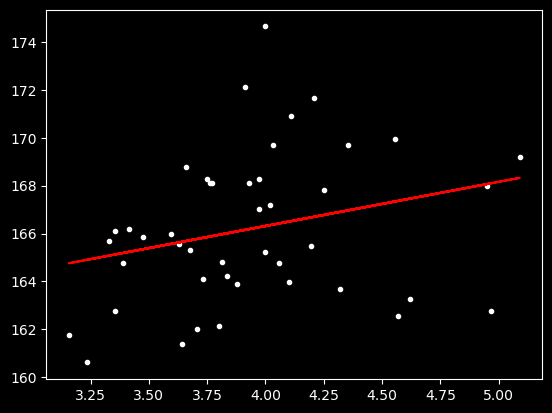

In [58]:
# plot binned results
fig, ax = plt.subplots()

ax.plot(df_binned['spike_rate'][1:-1], df_binned['wbf'][1:-1], 'w.') # , 'w.', ms=1, alpha=0.4)
ax.plot(df_binned['spike_rate'][1:-1], m*df_binned['spike_rate'][1:-1] + b, 'r-')

In [59]:
print(np.corrcoef(spike_rate, wbf))

[[1.     0.1767]
 [0.1767 1.    ]]


Text(0, 0.5, 'correlation')

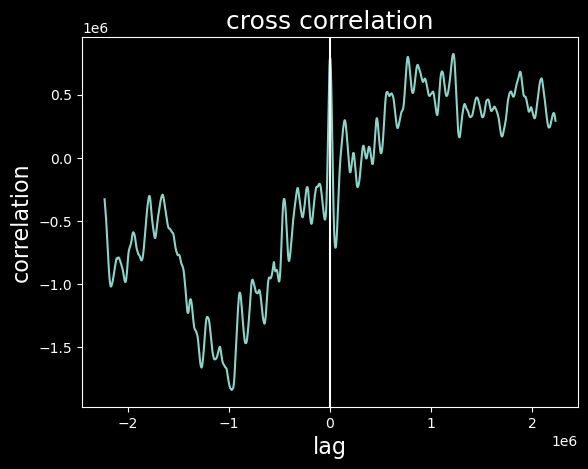

In [68]:
# try cross correlation
#x_tmp = np.linspace(0, 100, 1000)
#sig1 = np.sin(x_tmp)
#sig2 = np.cos(x_tmp)
mode='same'
sig1 = wbf
sig1 -= np.mean(sig1)
sig1 /= np.std(sig1)
sig2 = spike_rate
sig2 -= np.mean(sig2)
sig2 /= np.std(sig2)

corr = signal.correlate(sig1, sig2, mode=mode)
lags = signal.correlation_lags(len(sig1), len(sig2), mode=mode)

fig, ax = plt.subplots()

ax.plot(lags, corr)
ax.axvline(0, color='w')

# ax.set_xlim([-2, 2])
ax.set_title('cross correlation')
ax.set_xlabel('lag')
ax.set_ylabel('correlation')

In [69]:
# correlation without shift:
print('correlation without shift ', np.corrcoef(spike_rate[flying_idx], wbf[flying_idx])[0,1])

# correlation with shift:
spike_rate_shifted = np.roll(spike_rate, lags[np.argmax(corr)])
print('correlation with shift ', np.corrcoef(spike_rate_shifted[flying_idx], wbf[flying_idx])[0,1])

correlation without shift  0.3888923466521439
correlation with shift  0.32370414067567294


Text(0, 0.5, 'wbf (Hz)')

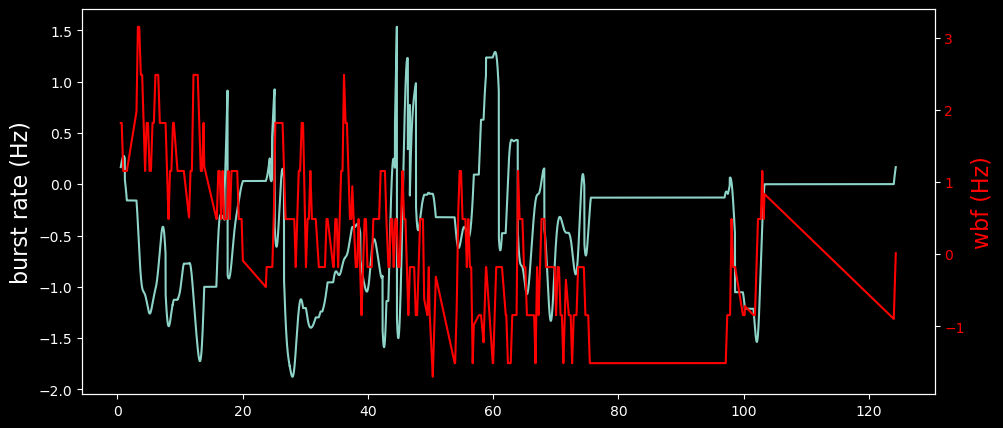

In [70]:
fig, ax0 = plt.subplots(figsize=(11, 5))

ax0.plot(t[flying_idx], np.roll(spike_rate[flying_idx], lags[np.argmax(corr)]))
ax0.set_ylabel('burst rate (Hz)') 

ax1 = ax0.twinx()
color = 'r'
ax1.plot(t[flying_idx], wbf[flying_idx], color='r')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('wbf (Hz)', color=color) 

Text(0.5, 1.0, 'wbf vs burst rate, kernel mult')

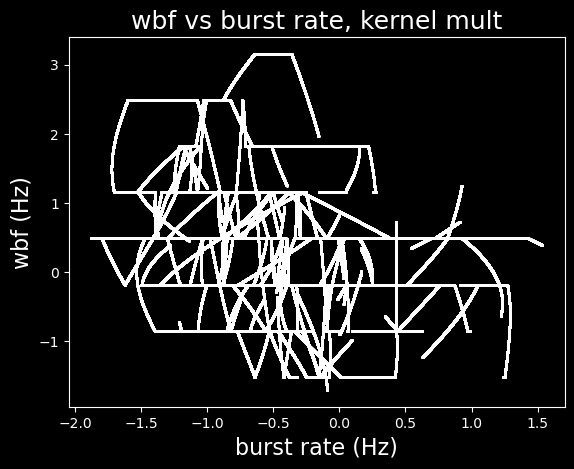

In [63]:
fig, ax = plt.subplots()

ax.plot(np.roll(spike_rate[flying_idx], lags[np.argmax(corr)]), wbf[flying_idx], 'w.', ms=1)

ax.set_xlabel('burst rate (Hz)')
ax.set_ylabel('wbf (Hz)')
ax.set_title('wbf vs burst rate, kernel mult')